In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show Code"></form>''')

# **Bank marketing predictions**

In [85]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

import matplotlib as mpl
import seaborn as sns

sns.set(style ='white',font_scale=1.25)

%matplotlib inline

## Load the data

In [86]:
bank_raw = pd.read_csv('../data/02-Bank-Marketing/bank-additional/bank-additional.csv',
                   sep=';',
                   na_values='unknown')
y = (bank_raw['y'] == 'yes').astype(int)

In [87]:
y.value_counts()

0    3668
1     451
Name: y, dtype: int64

In [88]:
bank = bank_raw.drop(labels=['y','duration'],axis=1)
bank.shape

(4119, 19)

In [89]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 19 columns):
age               4119 non-null int64
job               4080 non-null object
marital           4108 non-null object
education         3952 non-null object
default           3316 non-null object
housing           4014 non-null object
loan              4014 non-null object
contact           4119 non-null object
month             4119 non-null object
day_of_week       4119 non-null object
campaign          4119 non-null int64
pdays             4119 non-null int64
previous          4119 non-null int64
poutcome          4119 non-null object
emp.var.rate      4119 non-null float64
cons.price.idx    4119 non-null float64
cons.conf.idx     4119 non-null float64
euribor3m         4119 non-null float64
nr.employed       4119 non-null float64
dtypes: float64(5), int64(4), object(10)
memory usage: 611.5+ KB


Drop duration because it is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model

In [90]:
#bank.drop(labels='duration',axis=1,inplace=True)
bank.rename(columns={'day_of_week':'dayOfWeek'},inplace=True)

## Look for ourliers

Hit class percentage: 10.95%


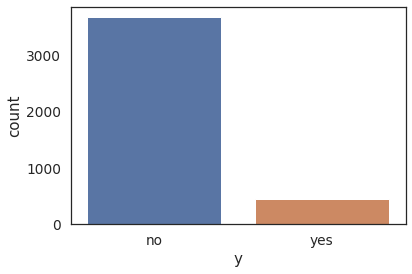

In [91]:
sns.countplot(x='y',data=bank_raw)
print('Hit class percentage: %.2f%%' %(100*y.mean()))

Imbalanced class

In [92]:
bank.isnull().sum(axis=1).sort_values(ascending=False)[:10]

1735    3
1254    3
2235    3
615     3
1676    3
896     3
2444    3
671     3
3630    3
1964    3
dtype: int64

At max an example has only 3 missing features. 

In [93]:
bank.isnull().sum()

age                 0
job                39
marital            11
education         167
default           803
housing           105
loan              105
contact             0
month               0
dayOfWeek           0
campaign            0
pdays               0
previous            0
poutcome            0
emp.var.rate        0
cons.price.idx      0
cons.conf.idx       0
euribor3m           0
nr.employed         0
dtype: int64

In [94]:
from collections import defaultdict

FEATURES = defaultdict(list)
missing_cat_table = pd.DataFrame()
for feature,num_null in bank.isnull().sum().iteritems():
    if feature != 'y':
        if bank[feature].dtypes == 'object':
            FEATURES['cat'].append(feature)
            percent_null = 100*(num_null/bank.shape[0])

            tmp_df = pd.DataFrame([feature,num_null,percent_null],index=['Feature','# of missing vals','% of missing vals']).T
            missing_cat_table = pd.concat([missing_cat_table,tmp_df],axis=0)
        else:
            FEATURES['cont'].append(feature)

missing_cat_table.sort_values(by='# of missing vals',ascending=False).reset_index(drop=True)

,Feature,# of missing vals,% of missing vals
0,default,803,19.495
1,education,167,4.05438
2,housing,105,2.54916
3,loan,105,2.54916
4,job,39,0.946832
5,marital,11,0.267055
6,contact,0,0
7,month,0,0
8,dayOfWeek,0,0
9,poutcome,0,0


In [95]:
FEATURES

defaultdict(list,
            {'cont': ['age',
              'campaign',
              'pdays',
              'previous',
              'emp.var.rate',
              'cons.price.idx',
              'cons.conf.idx',
              'euribor3m',
              'nr.employed'],
             'cat': ['job',
              'marital',
              'education',
              'default',
              'housing',
              'loan',
              'contact',
              'month',
              'dayOfWeek',
              'poutcome']})

## **Visualization**
Understand the categorical features

(array([  0., 100., 200., 300., 400., 500., 600.]),
 <a list of 7 Text xticklabel objects>)

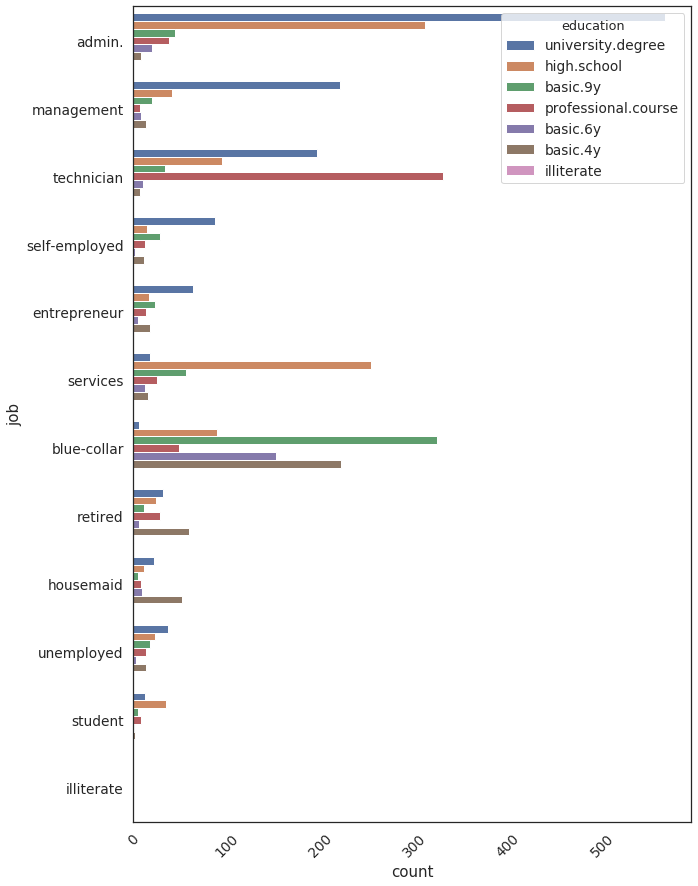

In [96]:
hue_order = ['university.degree',
             'high.school',
             'basic.9y',
             'professional.course',
             'basic.6y',
             'basic.4y',
             'illiterate']
order = ['admin.',
         'management',
         'technician',
         'self-employed',
         'entrepreneur',
         'services',
         'blue-collar',
         'retired',
         'housemaid',
         'unemployed',
         'student',
         'illiterate']
         
plt.figure(figsize=(10,15))
sns.countplot(y='job',hue='education',order=order,hue_order=hue_order,data=bank,orient='h')
plt.xticks(rotation=45)

In [97]:
ordinal_mapper = {'default':{'no':0,'yes':1},
                  'education':{'illiterate':0,
                               'basic.4y':1,
                               'basic.6y':2,
                               'professional.course':3,
                               'basic.9y':4,
                               'high.school':5,
                               'university.degree':6,
                               },
                  'housing':{'no':0,'yes':1},
                  'loan':{'no':0,'yes':1},
                  'job':{'illiterate':0,
                         'student':0,
                         'unemployed':1,
                         'housemaid':2,
                         'retired':3,
                         'blue-collar':4,
                         'services':5,
                         'entrepreneur':6,
                         'self-employed':7,
                         'technician':8,
                         'management':9,
                         'admin.':10
                        },
                  'contact':{'telephone':0,
                             'cellular':1
                            },
}

In [98]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,dayOfWeek,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1
1,39,services,single,high.school,no,no,no,telephone,may,fri,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1
3,38,services,married,basic.9y,no,NaN,NaN,telephone,jun,fri,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


In [99]:
bank = bank.replace(to_replace=ordinal_mapper)
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,dayOfWeek,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,30,4.0,married,4.0,0.0,1.0,0.0,1,may,fri,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1
1,39,5.0,single,5.0,0.0,0.0,0.0,0,may,fri,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0
2,25,5.0,married,5.0,0.0,1.0,0.0,0,jun,wed,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1
3,38,5.0,married,4.0,0.0,NaN,NaN,0,jun,fri,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1
4,47,10.0,married,6.0,0.0,1.0,0.0,1,nov,mon,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


In [100]:
FEATURES['ordinal']=list(ordinal_mapper.keys())
[FEATURES['cat'].remove(col) for col in FEATURES['ordinal']]

[None, None, None, None, None, None]

In [101]:
FEATURES

defaultdict(list,
            {'cont': ['age',
              'campaign',
              'pdays',
              'previous',
              'emp.var.rate',
              'cons.price.idx',
              'cons.conf.idx',
              'euribor3m',
              'nr.employed'],
             'cat': ['marital', 'month', 'dayOfWeek', 'poutcome'],
             'ordinal': ['default',
              'education',
              'housing',
              'loan',
              'job',
              'contact']})

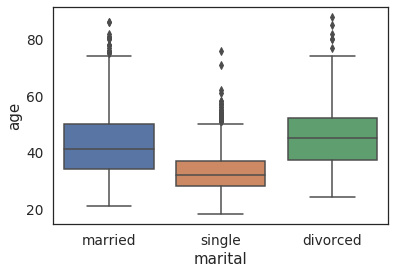

In [102]:
sns.boxplot(x='marital',y='age',data=bank)

In [103]:
bank[bank['marital'].isnull()]

,age,job,marital,education,default,housing,loan,contact,month,dayOfWeek,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
272,57,3.0,NaN,1.0,0.0,0.0,0.0,0,may,tue,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
882,35,7.0,NaN,6.0,0.0,0.0,0.0,1,nov,thu,1,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8
1049,37,1.0,NaN,6.0,0.0,0.0,0.0,1,jun,tue,1,999,0,nonexistent,-2.9,92.963,-40.8,1.262,5076.2
1289,59,3.0,NaN,6.0,NaN,0.0,0.0,0,may,tue,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1644,36,10.0,NaN,6.0,0.0,1.0,0.0,1,aug,wed,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1
1857,29,8.0,NaN,5.0,0.0,1.0,0.0,1,aug,wed,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1
2532,56,4.0,NaN,1.0,0.0,0.0,0.0,1,apr,fri,1,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1
2547,34,5.0,NaN,5.0,0.0,1.0,1.0,1,may,tue,2,999,1,failure,-1.8,92.893,-46.2,1.344,5099.1
2798,34,10.0,NaN,6.0,0.0,1.0,0.0,1,jul,thu,1,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1
3000,31,10.0,NaN,5.0,0.0,0.0,0.0,0,may,mon,8,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0


In [104]:
bank.groupby('marital')['age'].quantile(.75)['single']

37.0

In [105]:
def marital_imputer(df):
    if df['age'] < bank.groupby('marital')['age'].quantile(.75)['single']:
        return 'single'
    else:
        return bank['marital'].mode()[0]
    

In [106]:
bank.loc[bank['marital'].isnull(),'marital'] = bank.apply(marital_imputer,axis=1)

In [107]:
bank[bank_raw['marital'].isnull()]

,age,job,marital,education,default,housing,loan,contact,month,dayOfWeek,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
272,57,3.0,married,1.0,0.0,0.0,0.0,0,may,tue,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
882,35,7.0,single,6.0,0.0,0.0,0.0,1,nov,thu,1,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8
1049,37,1.0,married,6.0,0.0,0.0,0.0,1,jun,tue,1,999,0,nonexistent,-2.9,92.963,-40.8,1.262,5076.2
1289,59,3.0,married,6.0,NaN,0.0,0.0,0,may,tue,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1644,36,10.0,single,6.0,0.0,1.0,0.0,1,aug,wed,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1
1857,29,8.0,single,5.0,0.0,1.0,0.0,1,aug,wed,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1
2532,56,4.0,married,1.0,0.0,0.0,0.0,1,apr,fri,1,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1
2547,34,5.0,single,5.0,0.0,1.0,1.0,1,may,tue,2,999,1,failure,-1.8,92.893,-46.2,1.344,5099.1
2798,34,10.0,single,6.0,0.0,1.0,0.0,1,jul,thu,1,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1
3000,31,10.0,single,5.0,0.0,0.0,0.0,0,may,mon,8,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0


In [108]:
bank = pd.get_dummies(bank,drop_first=True)

In [109]:
bank.isnull().sum()

age                       0
job                      39
education               167
default                 803
housing                 105
loan                    105
contact                   0
campaign                  0
pdays                     0
previous                  0
emp.var.rate              0
cons.price.idx            0
cons.conf.idx             0
euribor3m                 0
nr.employed               0
marital_married           0
marital_single            0
month_aug                 0
month_dec                 0
month_jul                 0
month_jun                 0
month_mar                 0
month_may                 0
month_nov                 0
month_oct                 0
month_sep                 0
dayOfWeek_mon             0
dayOfWeek_thu             0
dayOfWeek_tue             0
dayOfWeek_wed             0
poutcome_nonexistent      0
poutcome_success          0
dtype: int64

In [110]:
FEATURES['cat']

['marital', 'month', 'dayOfWeek', 'poutcome']

In [111]:
to_impute_cols = ['age','job',
                  'default','education',
                  'housing','loan',
                  'marital_married',
                  'marital_single']

## Impute missing values using KNN imputer

In [112]:
from missingpy import KNNImputer, MissForest

In [113]:
#imputer = KNNImputer(n_neighbors=2,weights='distance')
imputer = MissForest()
bank[to_impute_cols] = pd.DataFrame(imputer.fit_transform(bank[to_impute_cols]),columns=to_impute_cols)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


In [114]:
bank.isnull().sum()

age                     0
job                     0
education               0
default                 0
housing                 0
loan                    0
contact                 0
campaign                0
pdays                   0
previous                0
emp.var.rate            0
cons.price.idx          0
cons.conf.idx           0
euribor3m               0
nr.employed             0
marital_married         0
marital_single          0
month_aug               0
month_dec               0
month_jul               0
month_jun               0
month_mar               0
month_may               0
month_nov               0
month_oct               0
month_sep               0
dayOfWeek_mon           0
dayOfWeek_thu           0
dayOfWeek_tue           0
dayOfWeek_wed           0
poutcome_nonexistent    0
poutcome_success        0
dtype: int64

In [115]:
bank.loc[bank['pdays']==999,'pdays'] = -1
bank.head()

,age,job,education,default,housing,loan,contact,campaign,pdays,previous,...,month_may,month_nov,month_oct,month_sep,dayOfWeek_mon,dayOfWeek_thu,dayOfWeek_tue,dayOfWeek_wed,poutcome_nonexistent,poutcome_success
0,30.0,4.0,4.0,0.0,1.000000,0.000000,1,2,-1,0,...,1,0,0,0,0,0,0,0,1,0
1,39.0,5.0,5.0,0.0,0.000000,0.000000,0,4,-1,0,...,1,0,0,0,0,0,0,0,1,0
2,25.0,5.0,5.0,0.0,1.000000,0.000000,0,1,-1,0,...,0,0,0,0,0,0,0,1,1,0
3,38.0,5.0,4.0,0.0,0.292206,0.467421,0,3,-1,0,...,0,0,0,0,0,0,0,0,1,0
4,47.0,10.0,6.0,0.0,1.000000,0.000000,1,1,-1,0,...,0,1,0,0,1,0,0,0,1,0


## **Feature Engineering**
- Check pairwise feature correlation
- Create interaction of feature pairs with high correlation (>0.4)

In [116]:
corr_df = bank.corr()

In [117]:
''' Create a dictionary with feature pairs as keys and their correlations as values'''
corr_dict = {}
for key, val in corr_df.unstack().to_dict().items():
    if (key == key[::-1]) or (key in corr_dict) or (key[::-1] in corr_dict):
        pass
    else:
        corr_dict[key] = val

In [118]:
'''Find feature pairs with corr > 0.4'''
high_corr_dict = {}
targetCorr = 0.4
for key, val in corr_dict.items():
    if val > targetCorr:
        high_corr_dict[key] = val
        
print('Total pairs with corr greater than %.2f: %i' %(targetCorr,len(high_corr_dict)))

'''Sort corr dict in descending order'''
from collections import OrderedDict
high_corr_dict = OrderedDict(sorted(high_corr_dict.items(), key=lambda x: x[1],reverse=True))
#print(high_corr_dict)

Total pairs with corr greater than 0.40: 15


In [119]:
interactions = []
for feat1, feat2 in high_corr_dict:
    bank['X'.join([feat1,feat2])] = bank[feat1] * bank[feat2]
    interactions.append('X'.join([feat1,feat2]))

## **Correlation with the target variable**
High correlations with newly engineered feature is a good indication

In [120]:
bank.corrwith(y,method='pearson').sort_values(ascending = False)[:10]

poutcome_success             0.325804
previousXpoutcome_success    0.305612
pdays                        0.271290
pdaysXpoutcome_success       0.266920
previous                     0.255697
pdaysXprevious               0.221360
month_mar                    0.164775
contact                      0.137401
month_sep                    0.119395
month_oct                    0.105684
dtype: float64

In [121]:
bank.corrwith(y).sort_values(ascending = False)[-10:]

emp.var.rateXeuribor3m           -0.233793
emp.var.rateXnr.employed         -0.281200
euribor3mXpoutcome_nonexistent   -0.281605
emp.var.rate                     -0.283216
emp.var.rateXcons.price.idx      -0.283585
cons.price.idxXeuribor3m         -0.297866
euribor3mXnr.employed            -0.298304
euribor3m                        -0.298565
cons.price.idxXnr.employed       -0.310298
nr.employed                      -0.349241
dtype: float64

## **Three-way interactions and some polynomial features**

In [51]:
bank['pdaysSq'] = bank['pdays']**2
bank['previousSq'] = bank['previous']**2
bank['pdaysXpreviousXpoutcome_success'] = bank['pdays']*bank['previous']*bank['poutcome_success']

bank['nr.employedSq'] = bank['nr.employed']**2
bank['euribor3mSq'] = bank['euribor3m']**2
bank['euribor3mXnr.employedXcons.price'] = bank['euribor3m']*bank['nr.employed']*bank['cons.conf.idx']

bank['emp.var.rateSq'] = bank['emp.var.rate']**2
bank['emp.var.rateXnr_employedXcons.price.idx'] = bank['emp.var.rate']*bank['nr.employed']*bank['cons.conf.idx']


In [52]:
bank.corrwith(y,method='spearman').sort_values(ascending = False)[:10]

pdays                                      0.331325
previousXpoutcome_success                  0.326988
poutcome_success                           0.325804
pdaysXpreviousXpoutcome_success            0.321251
pdaysSq                                    0.321166
pdaysXpoutcome_success                     0.320317
euribor3mXnr.employedXcons.price           0.256593
emp.var.rateXnr_employedXcons.price.idx    0.216796
previousSq                                 0.216074
previous                                   0.216074
dtype: float64

In [53]:
bank.corrwith(y).sort_values(ascending = False)[-10:]

euribor3mXpoutcome_nonexistent   -0.281605
euribor3mSq                      -0.281642
emp.var.rate                     -0.283216
emp.var.rateXcons.price.idx      -0.283585
cons.price.idxXeuribor3m         -0.297866
euribor3mXnr.employed            -0.298304
euribor3m                        -0.298565
cons.price.idxXnr.employed       -0.310298
nr.employedSq                    -0.348148
nr.employed                      -0.349241
dtype: float64

# **Building model**

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [55]:
X = bank.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (2883, 55)
X_test : (1236, 55)
y_train : (2883,)
y_test : (1236,)


## **Feature Standardize**

In [56]:
feat_to_norm = ['age','campaign','pdays',
                'previous','emp.var.rate',
                'cons.price.idx','cons.conf.idx',
                'euribor3m','nr.employed',
                'job', 'education']\
                + [inter for inter in interactions if len(inter.split('_')) < 3]\
                + ['pdaysSq','previousSq','pdaysXpreviousXpoutcome_success']\
                + ['nr.employedSq','euribor3mSq','euribor3mXnr.employedXcons.price']\
                + ['emp.var.rateSq','emp.var.rateXnr_employedXcons.price.idx']

In [57]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train[feat_to_norm])

X_num_train_norm = pd.DataFrame(ss.transform(X_train[feat_to_norm]),columns=feat_to_norm,index=X_train.index)
X_cat_train = X_train[[col for col in X_train.columns if col not in feat_to_norm]]
X_train_preproc = pd.concat([X_num_train_norm,X_cat_train],axis=1)

X_num_test_norm = pd.DataFrame(ss.transform(X_test[feat_to_norm]),columns=feat_to_norm,index=X_test.index)
X_cat_test = X_test[[col for col in X_test.columns if col not in feat_to_norm]]
X_test_preproc = pd.concat([X_num_test_norm,X_cat_test],axis=1)

In [58]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict


from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### **IMP Note**

We are interesed in predicting if the client will subscribe a bank term deposite based and their data. 
This can help in idenetifying types of clients that are most likely to subscribe. 
Knowing client types that are most likely to subscribe can help bank marketeer in carrring out targeted marketing campiang.

The postive (hit) class is only approximatly 11% of the total data. A 100% hit class recall (TRP)
with ressonable trade-off with false positve rate is acceptable. Hence, we want to build a classifier that yields high roc_auc_score,

In [59]:
def plot_precision_recall_vs_threshold(model,X_train_preproc,y_train):
    
    y_train_scores = cross_val_predict(model,X_train_preproc,y_train,
                                   cv=5,method="decision_function")
    precision, recalls, thresholds = precision_recall_curve(y_train,y_train_scores)
    
    plt.plot(thresholds,precision[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g--",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
    plt.figure()
    plt.plot(recalls,precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Presicion vs. Recall')
    return (precision, recalls)


def plot_roc_curve(model,X_train_preproc,y_train):
    y_train_scores = cross_val_predict(model,X_train_preproc,y_train,
                                   cv=5,method="decision_function")
    fpr,tpr,threshold = roc_curve(y_train,y_train_scores)
    plt.figure()
    plt.plot(fpr,tpr,linewidth = 2,label=None)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    
    return (fpr,tpr)

## **Dirty model**

In [68]:
threshold = 0.3

In [60]:
logit = LogisticRegression(penalty="l2",
                           random_state = 42,
                           class_weight='balanced',
                           solver = 'liblinear',
                           max_iter = 1000)

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


----------------------Accuracies-----------------------
Train accuracy: 0.4762
Test accuracy: 0.4660
----------------Precision-Recall Scores----------------
Train: 0.4559
Test: 0.4284
-------------------------------------------------------
f1 score: 0.2466
ROC and AUC scores: 0.6240
-------------------------------------------------------
Confusion matrix:
[[468 637]
 [ 23 108]]
-------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.42      0.59      1105
           1       0.14      0.82      0.25       131

    accuracy                           0.47      1236
   macro avg       0.55      0.62      0.42      1236
weighted avg       0.87      0.47      0.55      1236



/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceW

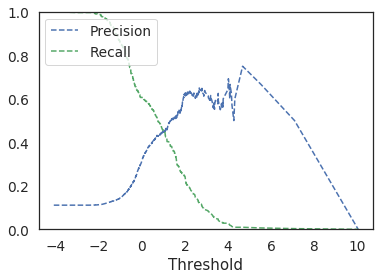

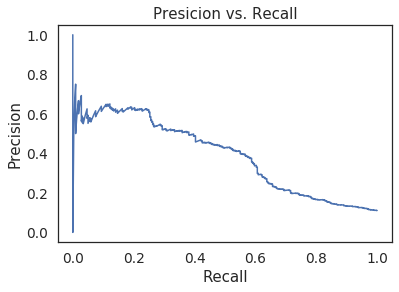

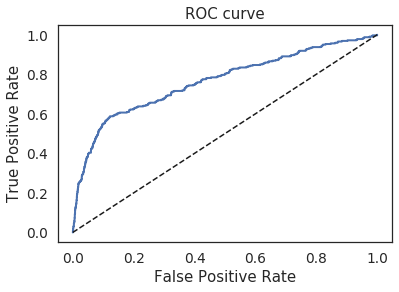

In [75]:
logit.fit(X_train_preproc,y_train)

y_train_prob = logit.predict_proba(X_train_preproc)[:,1]
y_train_pred = (y_train_prob > threshold).astype(int)

y_test_prob = logit.predict_proba(X_test_preproc)[:,1]
y_test_pred = (y_test_prob > threshold).astype(int)

y_scores_train = logit.decision_function(X_train_preproc)
y_scores_test = logit.decision_function(X_test_preproc)

print('-'*22+'Accuracies'+'-'*23)
print('Train accuracy: %.4f' %(accuracy_score(y_train,y_train_pred)))
print('Test accuracy: %.4f' %(accuracy_score(y_test,y_test_pred)))
print('-'*16+'Precision-Recall Scores'+'-'*16)
print('Train: %.4f' %(average_precision_score(y_train,y_scores_train)))
print('Test: %.4f'%(average_precision_score(y_test,y_scores_test)))
print('-'*55)
print('f1 score: %.4f' %(f1_score(y_test,y_test_pred)))
print('ROC and AUC scores: %.4f' %(roc_auc_score(y_test,y_test_pred)))
print('-'*55)
print('Confusion matrix:')
print(confusion_matrix(y_test,y_test_pred))
print('-'*55)
print('Classification report:')
print(classification_report(y_test,y_test_pred))

precision,recalls=plot_precision_recall_vs_threshold(logit,X_train_preproc,y_train)
fpr,tpr = plot_roc_curve(logit,X_train_preproc,y_train)

# **Model Building with CV**

In [71]:
from collections import namedtuple

models = namedtuple('models',['name','params','precision_recall_train','precision_recall_test'])
model_list = []

## **1. Logistic Regression with no regularization**

Precision-recall scoring criteria used to optimize the model.
When positive class is rare or when you care more about the false positive than the false negatives, and ROC score otherwise. 
Other scoring criteria can be found at https://scikit-learn.org/stable/modules/model_evaluation.html

In [72]:
param_grid = {'C':[0.0001, 0.0003, 0.0006, 
                   0.001, 0.003, 0.006, 0.01, 
                   0.03, 0.06, 0.1, 0.3, 0.6, 
                   1, 3, 6, 10, 30, 60, 100],
                 'class_weight':[None,'balanced'],
                 'solver':['newton-cg', 'lbfgs','sag','saga'],
             }
logit_cv = GridSearchCV(LogisticRegression(penalty='none',random_state=42),param_grid=param_grid,n_jobs=-1,cv=10,
                        scoring='recall')
logit_cv.fit(X_train_preproc,y_train)
logit_cv.best_estimator_

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='none', random_state=42, solver='saga', tol=0.0001,
                   verbose=0, warm_start=False)

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


----------------------Accuracies-----------------------
Train accuracy: 0.4762
Test accuracy: 0.4660
----------------Precision-Recall Scores----------------
Train: 0.4559
Test: 0.4284
-------------------------------------------------------
f1 score: 0.2466
ROC and AUC scores: 0.6240
-------------------------------------------------------
Confusion matrix:
[[468 637]
 [ 23 108]]
-------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.42      0.59      1105
           1       0.14      0.82      0.25       131

    accuracy                           0.47      1236
   macro avg       0.55      0.62      0.42      1236
weighted avg       0.87      0.47      0.55      1236



/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceW

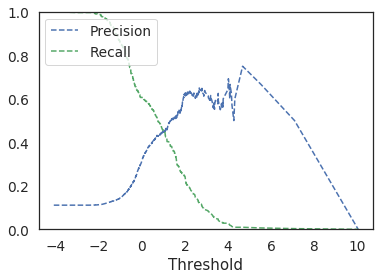

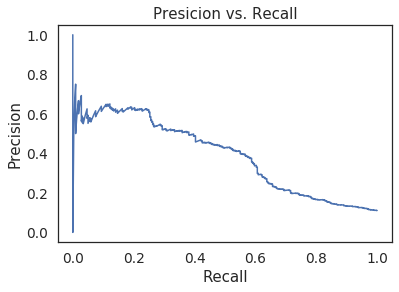

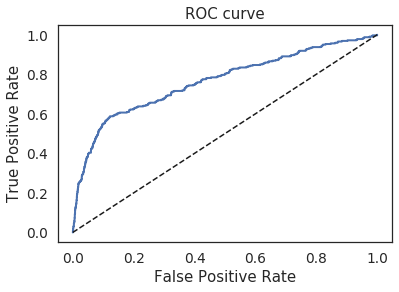

In [74]:
logit = LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='none', random_state=42, solver='saga', tol=0.0001,
                   verbose=0, warm_start=False)

logit.fit(X_train_preproc,y_train)

y_train_prob = logit.predict_proba(X_train_preproc)[:,1]
y_train_pred = (y_train_prob > threshold).astype(int)

y_test_prob = logit.predict_proba(X_test_preproc)[:,1]
y_test_pred = (y_test_prob > threshold).astype(int)

y_scores_train = logit.decision_function(X_train_preproc)
y_scores_test = logit.decision_function(X_test_preproc)

print('-'*22+'Accuracies'+'-'*23)
print('Train accuracy: %.4f' %(accuracy_score(y_train,y_train_pred)))
print('Test accuracy: %.4f' %(accuracy_score(y_test,y_test_pred)))
print('-'*16+'Precision-Recall Scores'+'-'*16)
print('Train: %.4f' %(average_precision_score(y_train,y_scores_train)))
print('Test: %.4f'%(average_precision_score(y_test,y_scores_test)))
print('-'*55)
print('f1 score: %.4f' %(f1_score(y_test,y_test_pred)))
print('ROC and AUC scores: %.4f' %(roc_auc_score(y_test,y_test_pred)))
print('-'*55)
print('Confusion matrix:')
print(confusion_matrix(y_test,y_test_pred))
print('-'*55)
print('Classification report:')
print(classification_report(y_test,y_test_pred))

precision,recalls=plot_precision_recall_vs_threshold(logit,X_train_preproc,y_train)
fpr,tpr = plot_roc_curve(logit,X_train_preproc,y_train)

model_list.append(models('logit',
                         logit,
                         average_precision_score(y_train,y_scores_train),
                         average_precision_score(y_test,y_scores_test)
                        )
                 )

## **2. Logistic regression with L2 regularization**

----------------------Accuracies-----------------------
Train accuracy: 0.1110
Test accuracy: 0.1060
----------------Precision-Recall Scores----------------
Train: 0.3948
Test: 0.3929
-------------------------------------------------------
f1 score: 0.1917
ROC and AUC scores: 0.5000
-------------------------------------------------------
Confusion matrix:
[[   0 1105]
 [   0  131]]
-------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1105
           1       0.11      1.00      0.19       131

    accuracy                           0.11      1236
   macro avg       0.05      0.50      0.10      1236
weighted avg       0.01      0.11      0.02      1236



/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


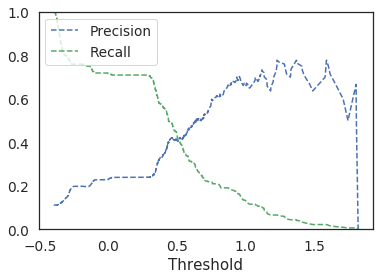

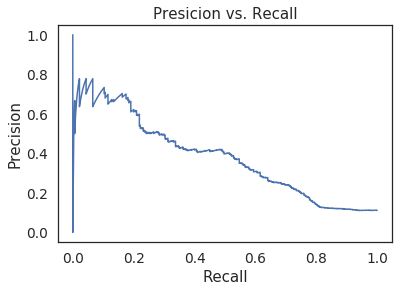

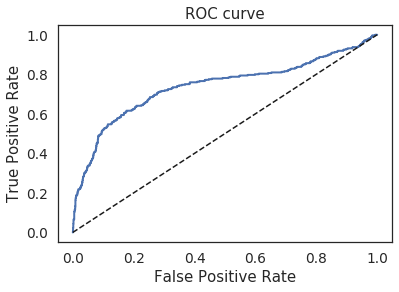

In [77]:
logit_l2 = LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                              fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                              max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                              random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                              warm_start=False)

logit_l2.fit(X_train_preproc,y_train)

y_train_prob = logit_l2.predict_proba(X_train_preproc)[:,1]
y_train_pred = (y_train_prob > threshold).astype(int)

y_test_prob = logit_l2.predict_proba(X_test_preproc)[:,1]
y_test_pred = (y_test_prob > threshold).astype(int)


y_scores_train = logit_l2.decision_function(X_train_preproc)
y_scores_test = logit_l2.decision_function(X_test_preproc)

print('-'*22+'Accuracies'+'-'*23)
print('Train accuracy: %.4f' %(accuracy_score(y_train,y_train_pred)))
print('Test accuracy: %.4f' %(accuracy_score(y_test,y_test_pred)))
print('-'*16+'Precision-Recall Scores'+'-'*16)
print('Train: %.4f' %(average_precision_score(y_train,y_scores_train)))
print('Test: %.4f'%(average_precision_score(y_test,y_scores_test)))
print('-'*55)
print('f1 score: %.4f' %(f1_score(y_test,y_test_pred)))
print('ROC and AUC scores: %.4f' %(roc_auc_score(y_test,y_test_pred)))
print('-'*55)
print('Confusion matrix:')
print(confusion_matrix(y_test,y_test_pred))
print('-'*55)
print('Classification report:')
print(classification_report(y_test,y_test_pred))

precision,recalls=plot_precision_recall_vs_threshold(logit_l2,X_train_preproc,y_train)
fpr,tpr = plot_roc_curve(logit_l2,X_train_preproc,y_train)

model_list.append(models('logit_l2',
                         logit_l2,
                         average_precision_score(y_train,y_scores_train),
                         average_precision_score(y_test,y_scores_test)
                        )
                 )

## **3. Logistic Regression with L1 regularization**

----------------------Accuracies-----------------------
Train accuracy: 0.1110
Test accuracy: 0.1060
----------------Precision-Recall Scores----------------
Train: 0.1110
Test: 0.1060
-------------------------------------------------------
f1 score: 0.1917
ROC and AUC scores: 0.5000
-------------------------------------------------------
Confusion matrix:
[[   0 1105]
 [   0  131]]
-------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1105
           1       0.11      1.00      0.19       131

    accuracy                           0.11      1236
   macro avg       0.05      0.50      0.10      1236
weighted avg       0.01      0.11      0.02      1236



/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


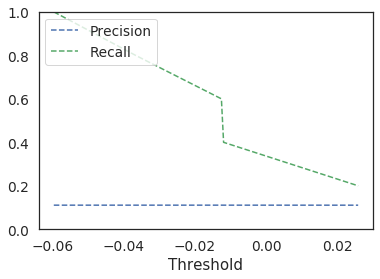

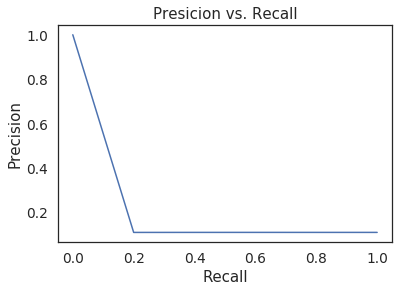

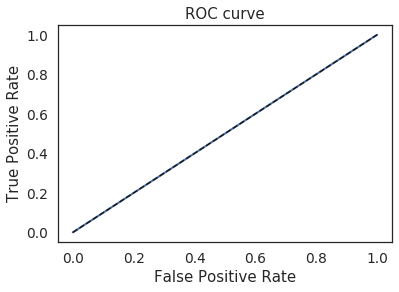

In [78]:
logit_l1 = LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

logit_l1.fit(X_train_preproc,y_train)

y_train_prob = logit_l1.predict_proba(X_train_preproc)[:,1]
y_train_pred = (y_train_prob > threshold).astype(int)

y_test_prob = logit_l1.predict_proba(X_test_preproc)[:,1]
y_test_pred = (y_test_prob > threshold).astype(int)


y_scores_train = logit_l1.decision_function(X_train_preproc)
y_scores_test = logit_l1.decision_function(X_test_preproc)

print('-'*22+'Accuracies'+'-'*23)
print('Train accuracy: %.4f' %(accuracy_score(y_train,y_train_pred)))
print('Test accuracy: %.4f' %(accuracy_score(y_test,y_test_pred)))
print('-'*16+'Precision-Recall Scores'+'-'*16)
print('Train: %.4f' %(average_precision_score(y_train,y_scores_train)))
print('Test: %.4f'%(average_precision_score(y_test,y_scores_test)))
print('-'*55)
print('f1 score: %.4f' %(f1_score(y_test,y_test_pred)))
print('ROC and AUC scores: %.4f' %(roc_auc_score(y_test,y_test_pred)))
print('-'*55)
print('Confusion matrix:')
print(confusion_matrix(y_test,y_test_pred))
print('-'*55)
print('Classification report:')
print(classification_report(y_test,y_test_pred))

precision,recalls=plot_precision_recall_vs_threshold(logit_l1,X_train_preproc,y_train)
fpr,tpr = plot_roc_curve(logit_l1,X_train_preproc,y_train)

model_list.append(models('logit_l1',
                         logit_l1,
                         average_precision_score(y_train,y_scores_train),
                         average_precision_score(y_test,y_scores_test)
                        )
                 )

In [79]:
model_list

[models(name='logit', params=LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='warn', n_jobs=None,
                    penalty='none', random_state=42, solver='saga', tol=0.0001,
                    verbose=0, warm_start=False), precision_recall_train=0.4558660457018554, precision_recall_test=0.42843985628421627),
 models(name='logit', params=LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='warn', n_jobs=None,
                    penalty='none', random_state=42, solver='saga', tol=0.0001,
                    verbose=0, warm_start=False), precision_recall_train=0.4558660457018554, precision_recall_test=0.42843985628421627),
 models(name='logit_l2', params=LogisticRegression(C=0.0001, class_weight='balanced', dual

## **SVM**

In [80]:
from sklearn.svm import SVC

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train accuracy:  0.9046132500867152
Test accuracy:  0.9053398058252428
---------------------------------------------------------------------------
Confusion matrix:
[[1097    8]
 [ 109   22]]
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1105
           1       0.73      0.17      0.27       131

    accuracy                           0.91      1236
   macro avg       0.82      0.58      0.61      1236
weighted avg       0.89      0.91      0.88      1236

f1 score: 0.2732919254658385
ROC and AUC scores:  0.5803495561465926


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/climbach/anaconda3/lib/python3.7/site-packa

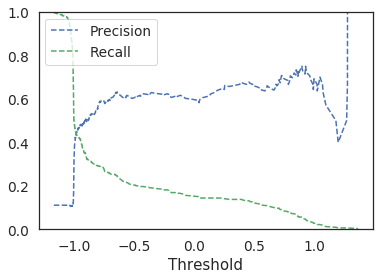

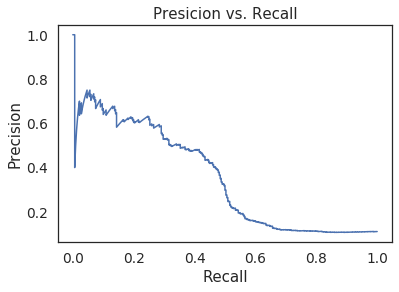

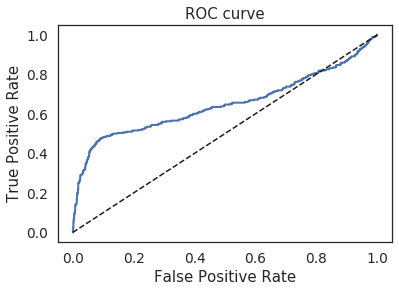

In [83]:
svm = SVC(probability=True)
svm.fit(X_train_preproc,y_train)

y_train_prob = svm.predict_proba(X_train_preproc)[:,1]
y_train_pred = (y_train_prob > threshold).astype(int)

y_test_prob = svm.predict_proba(X_test_preproc)[:,1]
y_test_pred = (y_test_prob > threshold).astype(int)


print('Train accuracy: ',accuracy_score(y_train,y_train_pred))
print('Test accuracy: ',accuracy_score(y_test,y_test_pred))
print('-'*75)
print('Confusion matrix:')
print(confusion_matrix(y_test,y_test_pred))
print('Classification report:')
print(classification_report(y_test,y_test_pred))
print('f1 score:',f1_score(y_test,y_test_pred))
print('ROC and AUC scores: ',roc_auc_score(y_test,y_test_pred))
_=precision,recalls=plot_precision_recall_vs_threshold(svm,X_train_preproc,y_train)
_=plot_roc_curve(svm,X_train_preproc,y_train)